In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from scipy.integrate import quad
import skfda
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis)
import torch
import torch.nn as nndata
import torch.optim as optim
from models import *
from dgp import *
from utils import *
from training import *

In [3]:
d = 500
# dim of  number of points in a curve * X_np is number of curves
X_np = dgp_fun(123, d, 101, "FAR_0.5_1")
X_np.shape

(101, 500)

In [4]:
def generate_Y_case1(X_np, J=5):
    n_points, n_curves = X_np.shape
    t_grid = np.linspace(0, 1, n_points)

    # Define beta_j(t) = sin((j+1) * pi * t), for j = 1 to J
    beta_mat = np.array([np.sin((j + 1) * np.pi * t_grid) for j in range(1, J + 1)])  # shape: (J, n_points)

    # Compute inner products ⟨β_j, X_t⟩
    delta_t = 1.0 / (n_points - 1)
    inner_prods = beta_mat @ X_np * delta_t  # (J × n_points) × (n_points × n_curves) => (J × n_curves)

    # Generate ε_t ~ N(0,1)
    eps = np.random.normal(0, 1, size=n_curves)

    # Final response: sum over J + noise
    Y_np = np.sum(inner_prods, axis=0) + eps  # sum over beta functions (rows)

    return Y_np


Y_np = generate_Y_case1(X_np, J=5)
Y_np.shape


(500,)

In [5]:
X = torch.tensor(X_np, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
print(Y.size())

torch.Size([101, 500])
torch.Size([1, 500])


# Model adding covariates

In [6]:
trunc_q = round(d/2)# the trunctation number
m = d**(1/5) # the bandwidth
print(m)
q = 4

3.465724215775732


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
/Users/xinyiwang/Desktop/Desktop - XINYI的MacBook Pro/UCDavis/research_alex/long-run-covariance/codes/models.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix[i, j] = torch.tensor(torch.sum(weighted_cross_cov), dtype=X.dtype, device=X.device)
/Users/xinyiwang/Desktop/Desktop - XINYI的MacBook Pro/UCDavis/research_alex/long-run-covariance/codes/models.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Epoch [200/10000], Loss: 9.5127
Epoch [400/10000], Loss: 7.8642
Epoch [600/10000], Loss: 6.1288
Epoch [800/10000], Loss: 4.4962
Epoch [1000/10000], Loss: 2.9662
Epoch [1200/10000], Loss: 1.9205
Epoch [1400/10000], Loss: 1.2464
Epoch [1600/10000], Loss: 0.7781
Epoch [1800/10000], Loss: 0.4660
Epoch [2000/10000], Loss: 0.2677
Epoch [2200/10000], Loss: 0.1477
Epoch [2400/10000], Loss: 0.0784
Epoch [2600/10000], Loss: 0.0401
Epoch [2800/10000], Loss: 0.0197
Epoch [3000/10000], Loss: 0.0093
Epoch [3200/10000], Loss: 0.0042
Epoch [3400/10000], Loss: 0.0018
Epoch [3600/10000], Loss: 0.0007
Epoch [3800/10000], Loss: 0.0003
Stopping early at Epoch [3991/10000], Loss: 0.000100

Restoring best model and weight network...


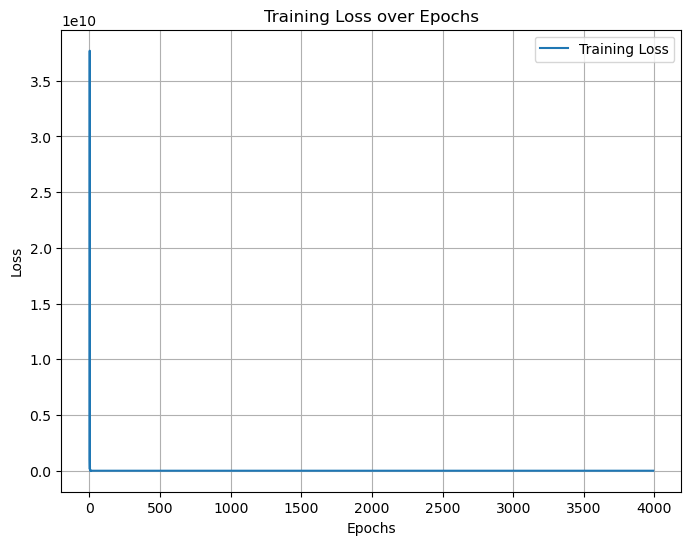

In [7]:
trained_model, trained_weight_net, learned_weights = train_model(X, Y, Weight_QS, Model1_new, LR_cov_X, m, q, trunc_q)


Shape of Covariance Matrix (NumPy): (101, 101)


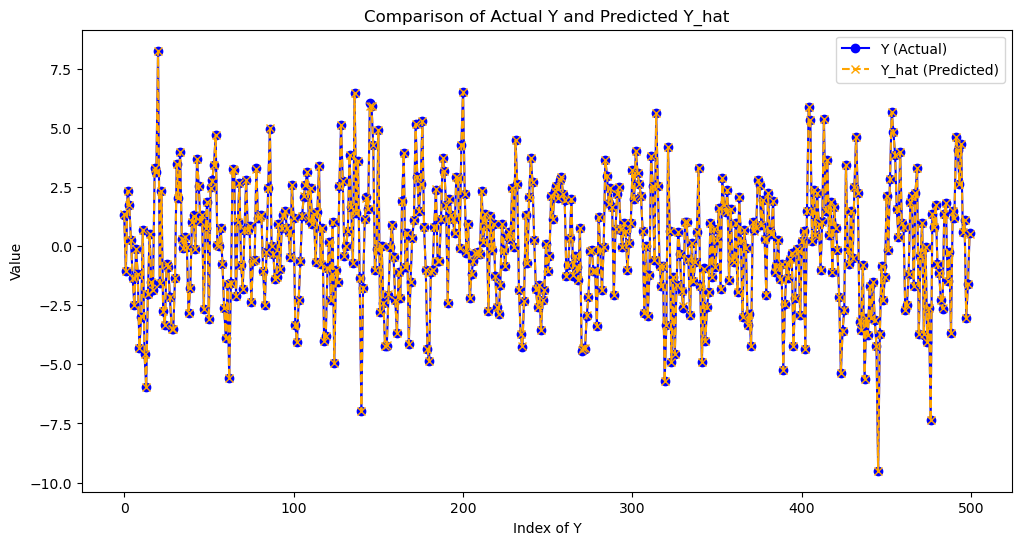

In [8]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_matrix, cov_matrix_w1, cov_matrix3 = LR_cov_X(X, trained_weight_net, trunc_q)
    cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


In [9]:
cov_matrix

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   3.1751,   2.7305,  ...,   5.1714,   5.6127,   5.6361],
        [  0.0000,   2.7724,   5.3780,  ...,   7.7929,   8.7388,   8.6400],
        ...,
        [  0.0000,   3.2992,   9.7715,  ..., 327.0214, 330.5245, 330.2370],
        [  0.0000,   3.3305,  10.1759,  ..., 325.2088, 331.7850, 331.6015],
        [  0.0000,   3.4631,  10.2997,  ..., 325.6574, 332.1959, 334.9113]])

In [10]:
sum(np.diag(cov_matrix))

np.float32(16132.222)

In [ ]:
import os
import pandas as pd
# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, f"cov_matrix_case1_FMA_{d}.csv")

# Convert matrices to DataFrames
df1 = pd.DataFrame(cov_matrix)
df2 = pd.DataFrame(cov_matrix_w1)
df3 = pd.DataFrame(cov_matrix3)

# Save matrices to CSV with an empty line between them
with open(csv_path, 'w', newline='') as f:
    df1.to_csv(f, index=False, header=False)
    f.write("\n")  # Write an empty line
    df2.to_csv(f, index=False, header=False)
    f.write("\n")  # Write another empty line
    df3.to_csv(f, index=False, header=False)

print(f"Saved matrices to {csv_path} with empty lines between them.")

# Compute true covariance matrix

In [ ]:
theoretical_cov_true = np.diag([3.24] * 5)

print(theoretical_cov_true)

In [ ]:
coefsE_on_btilde = E_coef_tilde2@ np.diag(norms)

In [ ]:
G_tilde = np.diag(1/norms) @ G @ np.diag(1/norms)

In [ ]:
hat_C = np.zeros((5, 5))

for l in range(5):
    for lp in range(5):
        sum1 = np.sum([coefsE_on_btilde[l, k] * G_tilde[:, k] for k in range(5)], axis=0)
        sum2 = np.sum([coefsE_on_btilde[lp, k] * G_tilde[:, k] for k in range(5)], axis=0)
        hat_C[l, lp] = np.sum([theoretical_cov_true[i, j] * sum1[i] * sum2[j] for i in range(5) for j in range(5)])
#print(np.round(hat_C,4))

In [ ]:
np.trace(hat_C)

In [ ]:
print(np.linalg.eigvals(hat_C))
sum(np.linalg.eigvals(hat_C))

In [ ]:
np.round(hat_C,4)

In [ ]:
cov_matrix

In [ ]:
fig = plot_matrices_2d([cov_matrix,cov_matrix_w1, cov_matrix3, hat_C], titles = ["our model", "all weights1", r"$\hat{\gamma}(0) + \hat{\gamma}(1) + \hat{\gamma}(-1)$", "true"])

In [ ]:
filename = f"figures/matrix3d_compare{d}_truc{trunc_q}_bd{round(m)}_q{q}.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free memory

print(f"Plot saved as {filename}")

In [ ]:
print("Sum of diagonal (cov_matrix):", torch.trace(cov_matrix))
print("Sum of diagonal (cov_matrix_w1):", torch.trace(cov_matrix_w1))
print("Sum of diagonal (cov_matrix3):", torch.trace(cov_matrix3))
print("Sum of diagonal (hat_C):", np.trace(hat_C))

In [ ]:
n = cov_matrix.shape[0]
delta = 1.0 / n

# Compute squared error via Riemann sum
L_T_h = np.sum((cov_matrix.detach().cpu().numpy() - hat_C) ** 2) * (delta ** 2)

print("L_{T,h} =", L_T_h)